# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score

from yellowbrick.cluster import KElbowVisualizer

In [2]:
# Import des données

data_customers = pd.read_csv('data_customers.csv')

display(data_customers.head())

,order_id,product_id,price,payment_type,payment_value,review_score,order_status,order_approved_at,order_delivered_customer_date,product_category_name,product_photos_qty,product_description_lenght,customer_unique_id,customer_state,order_delivered_days,panier_moyen
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.9,credit_card,72.19,5,delivered,2017-09-13 09:45:35,2017-09-20 23:43:48,cool_stuff,4.0,598.0,871766c5855e863f6eccc05f988b23cb,RJ,7,72.19
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,55.9,boleto,73.86,5,delivered,2017-06-29 02:44:11,2017-07-13 20:39:29,cool_stuff,4.0,598.0,0fb8e3eab2d3e79d92bb3fffbb97f188,GO,14,73.86
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,64.9,credit_card,83.23,4,delivered,2018-05-18 12:31:43,2018-06-04 18:34:26,cool_stuff,4.0,598.0,3419052c8c6b45daf79c1e426f9e9bcb,MG,17,83.23
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,58.9,credit_card,75.07,5,delivered,2017-08-01 18:55:08,2017-08-09 21:26:33,cool_stuff,4.0,598.0,e7c828d22c0682c1565252deefbe334d,PR,8,75.07
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,58.9,credit_card,72.19,5,delivered,2017-08-10 22:05:11,2017-08-24 20:04:21,cool_stuff,4.0,598.0,0bb98ba72dcc08e95f9d8cc434e9a2cc,MG,13,72.19


# Fonctions

In [3]:
def data_maintenance (end_date) :
    start_date = '2017-01-01'
    data = data_customers.query('date >= @start_date and date <= @end_date')
    
    # Créer une copie du DataFrame
    data_t = data.copy()
    
    # Création d'une date de référence
    snapshot_date = max(data_t['date']) + pd.DateOffset(days=1)
    
    # Initialisation du df
    features_df = data_features(data_t, snapshot_date)
    
    return features_df

In [4]:
def data_features(data_t, snapshot_date):
    
    def calculate_recency(x):
        return (snapshot_date - x.max()).days
    
    features = data_t.groupby('customer_unique_id').agg({
        'date': calculate_recency,
        'order_id': 'nunique',  # Frequency
        'payment_value': 'sum',  # Monetary
        'review_score' : 'mean',
        'panier_moyen': 'mean',
        'product_id' : 'nunique'
    }).rename(columns={
        'date' : 'Recency',
        'order_id': 'Frequency',
        'payment_value': 'Monetary',
        'review_score' : 'review_score_mean',
        'product_id' : 'qty_product'
        
    })
    features.reset_index(inplace=True)
    
    return features

In [5]:
def k_means_clustering_month(end_date, n_clusters=3):
    # Initialisation de la période t0 
    data_customers_t0 = data_maintenance('2017-06-01')
    colonnes_numeriques = ['Recency', 'Frequency', 'Monetary', 'review_score_mean']
    data_customers_cluster = data_customers_t0[colonnes_numeriques]
    
    # Standardiser les données pour la période t0
    scaler = StandardScaler()
    data_sc_t0 = scaler.fit_transform(data_customers_cluster)
    
    # Initialiser le modèle KMeans pour la première itération
    kmeans_t0 = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    
    # Appliquer KMeans sur les données transformées de la période t0
    data_predict_t0 = kmeans_t0.fit_predict(data_sc_t0)
    
    # Ajouter les étiquettes de cluster au DataFrame original de la période t0
    data_customers_t0['Cluster_0'] = data_predict_t0
    
    date = pd.to_datetime('2017-05-01')
    i = 0
    data_customers_t = {}  # Dictionnaire pour stocker les DataFrames par itération
    ari_df = pd.DataFrame(columns=['Date', 'ARI'])
    
    while date <= end_date:
        i += 1
        date += pd.DateOffset(months=1)
        data_customers_cluster = data_maintenance(date)
        
        # Colonnes numériques à utiliser pour le clustering
        data_customers_t[i] = data_customers_cluster[colonnes_numeriques].copy()
        
        # Transformer les données de la période i avec le scaler ajusté sur la période t0
        data_sc_i = scaler.transform(data_customers_t[i])
        
        # Predict avec l'ancien modèle (kmeans_t0) sur le nouveau df
        data_predict_0 = kmeans_t0.predict(data_sc_i)

        # Initialiser un nouveau modèle KMeans (kmeans_t1)
        kmeans_t1 = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

        # Predict avec le nouveau modèle kmeans_t1 sur le nouveau df
        data_predict_1 = kmeans_t1.fit_predict(data_sc_i)
        
        # Ajouter les étiquettes de cluster au DataFrame original
        data_customers_t[i].loc[:, 'Cluster'] = data_predict_1

        # Calculer l'ARI
        ari_1 = adjusted_rand_score(data_predict_0, data_predict_1)
        ari_df = pd.concat([ari_df, pd.DataFrame({'Date': [date], 'ARI': [ari_1]})], ignore_index=True)

        
    # Tracer le graphique des valeurs ARI
    plt.plot(ari_df['Date'], ari_df['ARI'], marker='o')
    plt.title('ARI')
    plt.xlabel('Date')
    plt.ylabel('ARI')
    plt.xticks(ari_df['Date'],rotation=45)
    plt.grid(True)
    plt.show()

In [6]:
def k_means_clustering_week(end_date, n_clusters=3):
    # Initialisation de la période t0 
    data_customers_t0 = data_maintenance("2017-06-01")
    colonnes_numeriques = ['Recency', 'Frequency', 'Monetary', 'review_score_mean']
    data_customers_cluster = data_customers_t0[colonnes_numeriques]
    
    # Standardiser les données pour la période t0
    scaler = StandardScaler()
    data_sc_t0 = scaler.fit_transform(data_customers_cluster)
    
    # Initialiser le modèle KMeans pour la première itération
    kmeans_t0 = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    
    # Appliquer KMeans sur les données transformées de la période t0
    data_predict_t0 = kmeans_t0.fit_predict(data_sc_t0)
    
    # Ajouter les étiquettes de cluster au DataFrame original de la période t0
    data_customers_t0['Cluster_0'] = data_predict_t0
    
    date = pd.to_datetime('2017-05-25')
    i = 0
    data_customers_t = {}  # Dictionnaire pour stocker les DataFrames par itération
    ari_df = pd.DataFrame(columns=['Date', 'ARI'])
    
    while date <= end_date:
        i += 1
        date += pd.DateOffset(weeks=1)
        data_customers_cluster = data_maintenance(date)
        
        # Colonnes numériques à utiliser pour le clustering
        data_customers_t[i] = data_customers_cluster[colonnes_numeriques].copy()
        
        # Transformer les données de la période i avec le scaler ajusté sur la période t0
        data_sc_i = scaler.transform(data_customers_t[i])
        
        # Predict avec l'ancien modèle (kmeans_t0) sur le nouveau df
        data_predict_0 = kmeans_t0.predict(data_sc_i)

        # Initialiser un nouveau modèle KMeans (kmeans_t1)
        kmeans_t1 = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

        # Predict avec le nouveau modèle kmeans_t1 sur le nouveau df
        data_predict_1 = kmeans_t1.fit_predict(data_sc_i)
        
        # Ajouter les étiquettes de cluster au DataFrame original
        data_customers_t[i].loc[:, 'Cluster'] = data_predict_1

        # Calculer l'ARI
        ari_1 = adjusted_rand_score(data_predict_0, data_predict_1)
        ari_df = pd.concat([ari_df, pd.DataFrame({'Date': [date], 'ARI': [ari_1]})], ignore_index=True)

        
    # Tracer le graphique des valeurs ARI
    plt.plot(ari_df['Date'], ari_df['ARI'], marker='o')
    plt.title('ARI')
    plt.xlabel('Date')
    plt.ylabel('ARI')
    plt.xticks(ari_df['Date'],rotation=90)
    plt.grid(True)
    plt.show()

In [7]:
def km_cluster_maintenance(end_date,n_clusters):
    # Initialisation de la période t0 
    data_customers_t0 = data_maintenance("2017-06-01")
    colonnes_numeriques = ['Recency', 'Frequency', 'Monetary', 'review_score_mean']
    data_customers_cluster = data_customers_t0[colonnes_numeriques]
    
    # Standardiser les données pour la période t0
    scaler = StandardScaler()
    data_sc_t0 = scaler.fit_transform(data_customers_cluster)
    
    # Initialiser le modèle KMeans pour la première itération
    kmeans_t0 = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    
    # Appliquer KMeans sur les données transformées de la période t0
    data_predict_t0 = kmeans_t0.fit_predict(data_sc_t0)
    
    # Ajouter les étiquettes de cluster au DataFrame original de la période t0
    data_customers_t0['Cluster_0'] = data_predict_t0
    
    # Dictionnaire pour stocker le nombre de clients par cluster
    cluster_counts = {cluster: [] for cluster in range(n_clusters)} 
    count_dates = []  # Liste pour stocker les dates correspondant aux comptages des clients
    
    # Dictionnaires pour stocker les indices
    ch_scores = []
    db_scores = []
    silhouette_scores = []
    
    date = pd.to_datetime('2017-05-25')
    i = 0
    data_customers_t = {}  # Dictionnaire pour stocker les DataFrames par itération
    ari_df = pd.DataFrame(columns=['Date', 'ARI'])
    
    while date <= end_date:
        i += 1
        date += pd.DateOffset(weeks=1)
        data_customers_cluster = data_maintenance(date)
        
        if i % 6 == 0:
            # Ajouter la date actuelle à la liste des dates de comptage
            count_dates.append(date)  
            
            # Phase de maintenance, réentraîner le modèle initial
            kmeans_t0 = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            data_customers_t0 = data_maintenance(date)  # Données pour la réentrainement
            data_customers_cluster = data_customers_t0[colonnes_numeriques]  # Colonnes numériques
            data_sc_t0 = scaler.fit_transform(data_customers_cluster)  # Données transformées
            data_predict_t0 = kmeans_t0.fit_predict(data_sc_t0)  # Prédiction
            data_customers_t0['Cluster_0'] = data_predict_t0  # Ajout des étiquettes au DataFrame initial
            
            # Nombre de client par cluster
            counts = data_customers_t0['Cluster_0'].value_counts()
            for cluster in range(n_clusters):
                cluster_counts[cluster].append(counts.get(cluster, 0))
                
            # Calculer les scores CH, DB et Silhouette
            ch_score = calinski_harabasz_score(data_sc_t0, data_predict_t0)
            db_score = davies_bouldin_score(data_sc_t0, data_predict_t0)
            silhouette_avg = silhouette_score(data_sc_t0, data_predict_t0)
            ch_scores.append(ch_score)
            db_scores.append(db_score)
            silhouette_scores.append(silhouette_avg)
        
        # Colonnes numériques à utiliser pour le clustering
        data_customers_t[i] = data_customers_cluster[colonnes_numeriques].copy()
        
        # Transformer les données de la période i avec le scaler ajusté sur la période t0
        data_sc_i = scaler.transform(data_customers_t[i])
        
        # Predict avec l'ancien modèle (kmeans_t0) sur le nouveau df
        data_predict_0 = kmeans_t0.predict(data_sc_i)

        # Initialiser un nouveau modèle KMeans (kmeans_t1)
        kmeans_t1 = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

        # Predict avec le nouveau modèle kmeans_t1 sur le nouveau df
        data_predict_1 = kmeans_t1.fit_predict(data_sc_i)
        
        # Ajouter les étiquettes de cluster au DataFrame original
        data_customers_t[i].loc[:, 'Cluster'] = data_predict_1

        # Calculer l'ARI
        ari_1 = adjusted_rand_score(data_predict_0, data_predict_1)
        ari_df = pd.concat([ari_df, pd.DataFrame({'Date': [date], 'ARI': [ari_1]})], ignore_index=True)
            
    # Convertir cluster_counts en DataFrame
    cluster_counts_df = pd.DataFrame(cluster_counts, index=count_dates)
    
    # Convertir les scores CH et DB en DataFrame
    ch_db_df = pd.DataFrame({'Date': count_dates, 'CH_Score': ch_scores, 'DB_Score': db_scores,
                             'Silhouette_Score': silhouette_scores})
    
    return cluster_counts_df, ari_df, ch_db_df

In [8]:
def plot_cluster_counts(cluster_counts_df):
    plt.figure(figsize=(10, 6))
    for cluster in cluster_counts_df.columns:
        plt.plot(cluster_counts_df.index, cluster_counts_df[cluster], label=f'Cluster {cluster}',marker='o')
    plt.title('Évolution du nombre de clients par cluster')
    plt.xlabel('Date')
    plt.ylabel('Nombre de clients')
    plt.legend()
    plt.xticks(cluster_counts_df.index)
    plt.grid(True)
    plt.show()

In [9]:
def ari_graph(ari_df) : 
    # Tracer le graphique des valeurs ARI
    plt.plot(ari_df['Date'], ari_df['ARI'], marker='o')
    plt.title('ARI')
    plt.xlabel('Date')
    plt.ylabel('ARI')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

In [10]:
def plot_ch_db_scores(ch_db_df):
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))

    # Premier graphique : CH 
    axs[0].plot(ch_db_df['Date'], ch_db_df['CH_Score'], marker='o', label='Calinski-Harabasz Index')
    axs[0].set_title('Calinski-Harabasz')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Score')
    axs[0].set_xticks(ch_db_df['Date'])
    axs[0].legend()
    axs[0].grid(True)

    # Deuxième graphique : Silhouette Score
    axs[1].plot(ch_db_df['Date'], ch_db_df['DB_Score'], marker='o', label='Davies-Bouldin Index')
    axs[1].set_title('Davies-Bouldin')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Score')
    axs[1].set_xticks(ch_db_df['Date'])
    axs[1].legend()
    axs[1].grid(True)
    
    # Troisième graphique : Silhouette Score
    axs[2].plot(ch_db_df['Date'], ch_db_df['Silhouette_Score'], marker='o', label='Silhouette Score')
    axs[2].set_title('Silhouette_Score')
    axs[2].set_xlabel('Date')
    axs[2].set_ylabel('Score')
    axs[2].set_xticks(ch_db_df['Date'])
    axs[2].legend()
    axs[2].grid(True)


    # Rotation des étiquettes de l'axe x pour une meilleure lisibilité
    for ax in axs:
        plt.setp(ax.get_xticklabels(), rotation=90)

    plt.tight_layout()
    plt.show()

# Initialisation

## Date

In [11]:
# Renommer la colonne 'order_approved_at' en 'date'

data_customers = data_customers.rename(columns={'order_approved_at' : 'date'})

# Ne garder que les dates jj/mm/aaaa

# Conversion de la colonne 'date' en type datetime
data_customers['date'] = pd.to_datetime(data_customers['date'])

data_customers['date'] = data_customers['date'] = data_customers['date'].dt.date

display(data_customers.head())

,order_id,product_id,price,payment_type,payment_value,review_score,order_status,date,order_delivered_customer_date,product_category_name,product_photos_qty,product_description_lenght,customer_unique_id,customer_state,order_delivered_days,panier_moyen
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.9,credit_card,72.19,5,delivered,2017-09-13,2017-09-20 23:43:48,cool_stuff,4.0,598.0,871766c5855e863f6eccc05f988b23cb,RJ,7,72.19
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,55.9,boleto,73.86,5,delivered,2017-06-29,2017-07-13 20:39:29,cool_stuff,4.0,598.0,0fb8e3eab2d3e79d92bb3fffbb97f188,GO,14,73.86
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,64.9,credit_card,83.23,4,delivered,2018-05-18,2018-06-04 18:34:26,cool_stuff,4.0,598.0,3419052c8c6b45daf79c1e426f9e9bcb,MG,17,83.23
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,58.9,credit_card,75.07,5,delivered,2017-08-01,2017-08-09 21:26:33,cool_stuff,4.0,598.0,e7c828d22c0682c1565252deefbe334d,PR,8,75.07
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,58.9,credit_card,72.19,5,delivered,2017-08-10,2017-08-24 20:04:21,cool_stuff,4.0,598.0,0bb98ba72dcc08e95f9d8cc434e9a2cc,MG,13,72.19


## Analyse comportement d'achat par date

In [12]:
data_order_date = data_customers[['order_id','date']]
data_order_date = data_order_date.sort_values(by='date', ascending=True)
display(data_order_date.head(), data_order_date.tail())

,order_id,date
92426,63638a6806d67773f3adba8534553fff,2016-10-04
86874,4d66b3a9d12facad48a3b23cc9fe7898,2016-10-04
78871,36989eb07a0de2d3d3129eea35553875,2016-10-04
78872,36989eb07a0de2d3d3129eea35553875,2016-10-04
92427,63638a6806d67773f3adba8534553fff,2016-10-04


,order_id,date
48974,bee12e8653a04e76786e8891cfb6330a,2018-08-29
48973,bee12e8653a04e76786e8891cfb6330a,2018-08-29
46951,c84d88553f9878bf2c7ecda2eb211ece,2018-08-29
109447,d4fae577806d683110e00e18a5e181be,2018-08-29
44522,0b223d92c27432930dfe407c6aea3041,2018-08-29


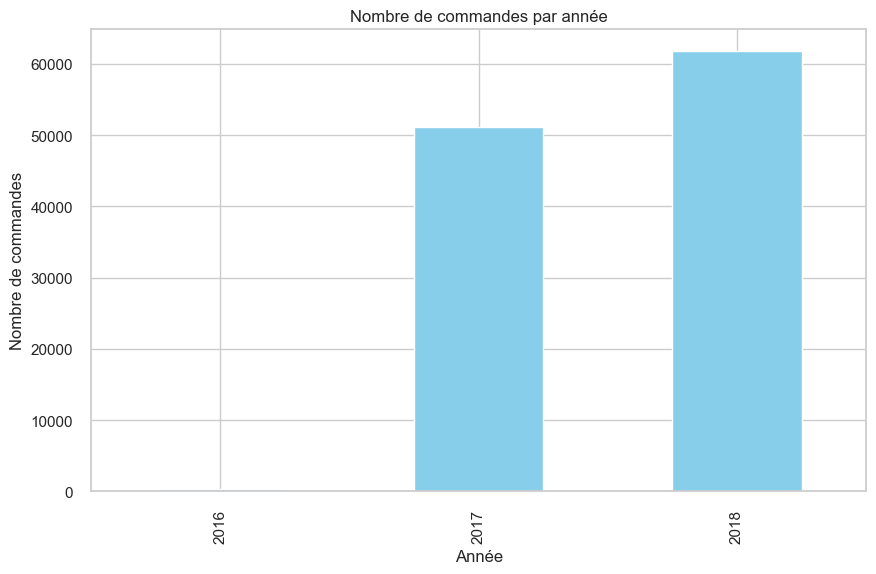

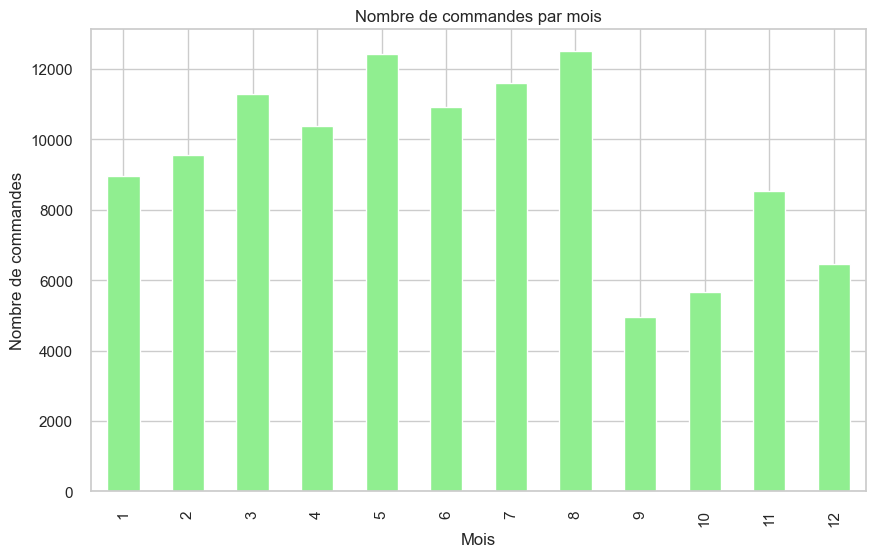

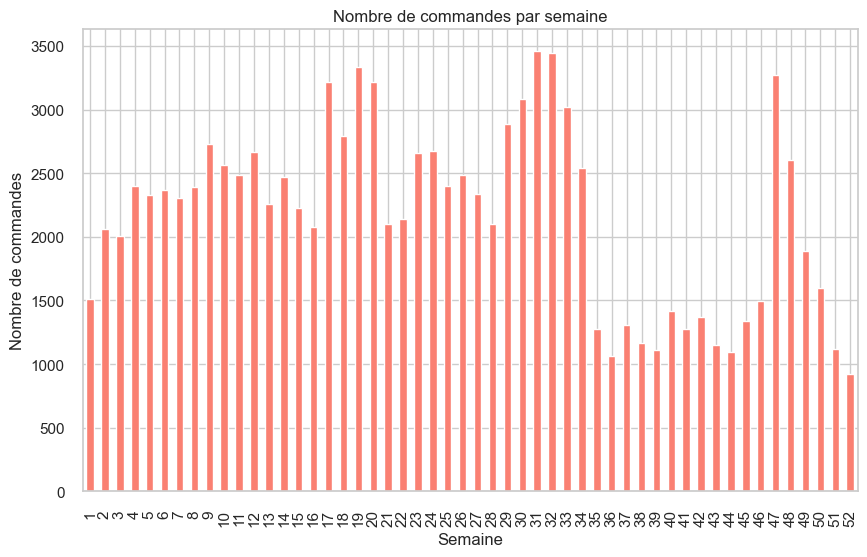

In [13]:
# Conversion de la colonne 'date' en type datetime
data_customers['date'] = pd.to_datetime(data_customers['date'])

# Créer un DataFrame séparé pour les dates des commandes
data_order_date = data_customers[['order_id', 'date']].copy()

# Extraire année, mois et semaine
data_order_date['year'] = data_order_date['date'].dt.year
data_order_date['month'] = data_order_date['date'].dt.month
data_order_date['week'] = data_order_date['date'].dt.isocalendar().week

# Nombre de commandes par année, mois et semaine
orders_by_year = data_order_date.groupby('year').size()
orders_by_month = data_order_date.groupby('month').size()
orders_by_week = data_order_date.groupby('week').size()

# Paramètres de style pour les graphiques
sns.set(style="whitegrid")

# Graphique du nombre de commandes par année
plt.figure(figsize=(10, 6))
orders_by_year.plot(kind='bar', color='skyblue')
plt.title('Nombre de commandes par année')
plt.xlabel('Année')
plt.ylabel('Nombre de commandes')
plt.show()

# Graphique du nombre de commandes par mois
plt.figure(figsize=(10, 6))
orders_by_month.plot(kind='bar', color='lightgreen')
plt.title('Nombre de commandes par mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de commandes')
plt.show()

# Graphique du nombre de commandes par semaine
plt.figure(figsize=(10, 6))
orders_by_week.plot(kind='bar', color='salmon')
plt.title('Nombre de commandes par semaine')
plt.xlabel('Semaine')
plt.ylabel('Nombre de commandes')
plt.show()

**COMMENTAIRE**

Au vu du nombre de commande il est possible de faire la maintenance au minimum par semaine. 

/var/folders/sg/93kbc44x3dz8s65w44mhwm100000gn/T/ipykernel_15525/773560846.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year_month'] = filtered_data['date'].dt.to_period('M')


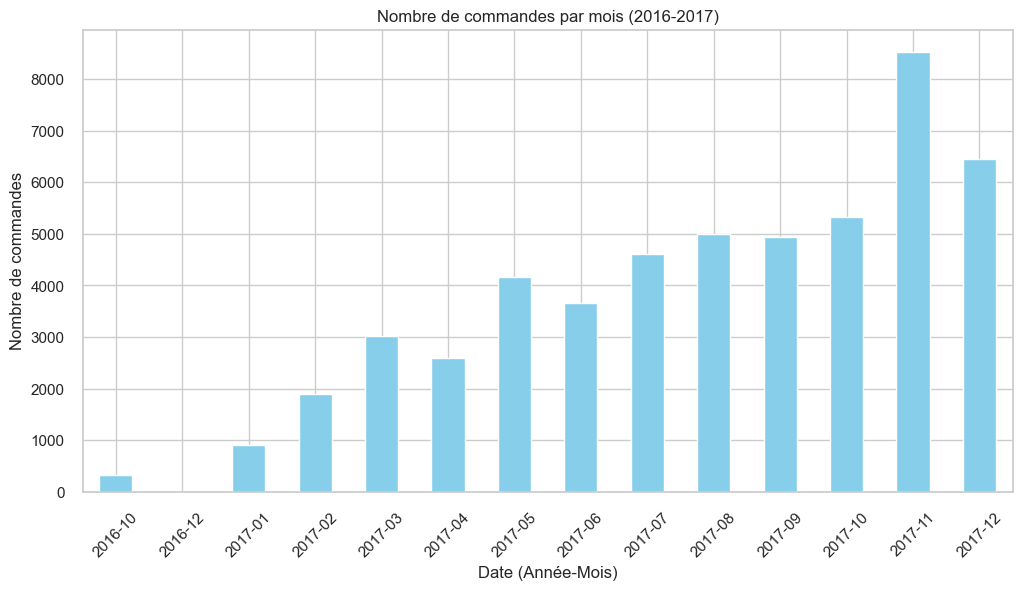

In [14]:
# Filtrer les données pour inclure uniquement les années 2016 et 2017
filtered_data = data_order_date[(data_order_date['year'] >= 2016) & (data_order_date['year'] <= 2017)]

# Grouper par année et mois pour obtenir le nombre de commandes par mois
filtered_data['year_month'] = filtered_data['date'].dt.to_period('M')
orders_per_month = filtered_data.groupby('year_month').size()

# Tracer le graphique
plt.figure(figsize=(12, 6))
orders_per_month.plot(kind='bar', color='skyblue')
plt.title('Nombre de commandes par mois (2016-2017)')
plt.xlabel('Date (Année-Mois)')
plt.ylabel('Nombre de commandes')
plt.xticks(rotation=45)
plt.show()

**COMMENTAIRE**

On remarque que les commandes sont régulières à partir de janvier 2017, on fixera l'initialisation de la maintenant à partir de cette date.
Afin d'avoir des données suffisantes afin qu'elles soient représentatives nous prendrons t0 sur 4 mois.

# Test maintenance

Test pour déterminer le nombre de semaine d'initialisation afin d'avoir une première maintenance dans un délai acceptable du point de vue métier. 

**Months**
![Texte alternatif](ARI_month_4M.png)

**Weeks**
![Texte alternatif](ARI_weeks_4M.png)

**COMMENTAIRE**

On remarque que la courbe décroit assez rapidement si on prend 4 mois d'initialisation, ce qui donne une maintenance toutes les 2 semaines environs pour toujours garder un score ARI au dessus de 0,6. 


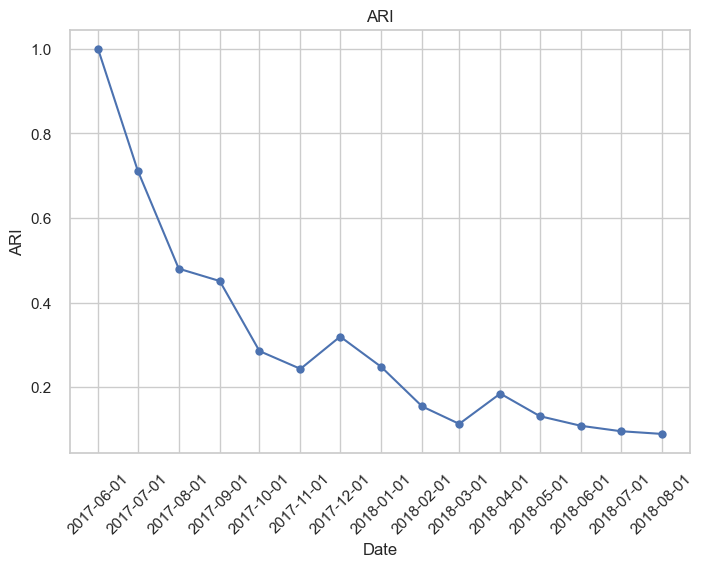

In [15]:
# Initialisation avec 6 mois
end_date = pd.to_datetime('2018-07-01')
k_means_clustering_month(end_date,n_clusters=4)

# Maintenance par semaine

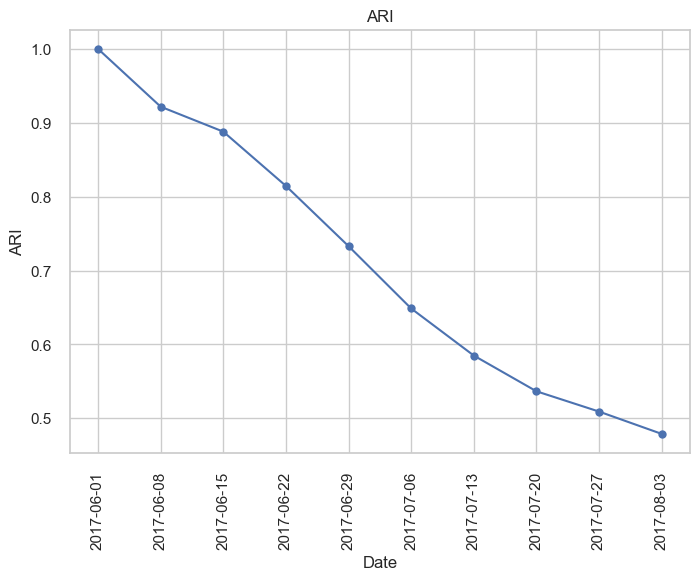

In [16]:
end_date = pd.to_datetime('2017-08-01')
k_means_clustering_week(end_date,n_clusters=4)

**COMMENTAIRE**

En initialisant les données sur 6 mois on obtient une première maintenance au bout de 4 semaines

# Phase de maintenance

**Maintenance toutes les 4 semaines**
![Texte alternatif](ARI_weeks_4M_maintenance5W.png)

**Maintenance toutes les 5 semaines**
![Texte alternatif](ARI_weeks_4M_maintenance6W.png)

In [17]:
end_date = pd.to_datetime('2018-06-01')
cluster_counts_df, ari_df, ch_db_df = km_cluster_maintenance(end_date, n_clusters=4)

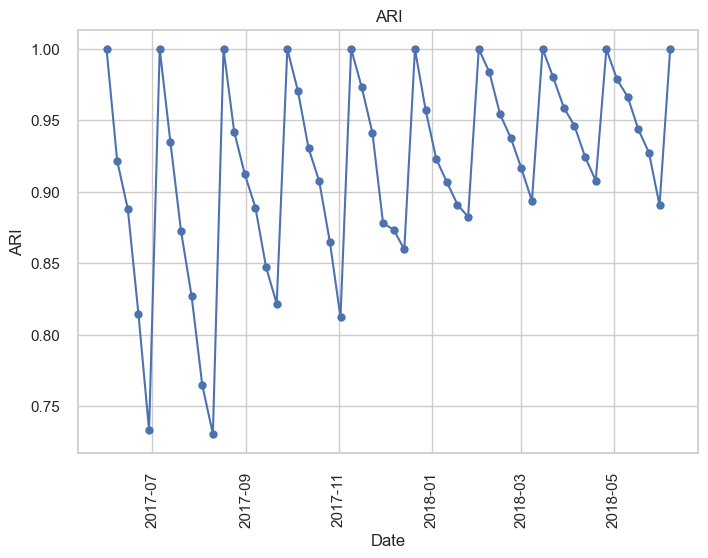

In [18]:
ari_graph(ari_df)

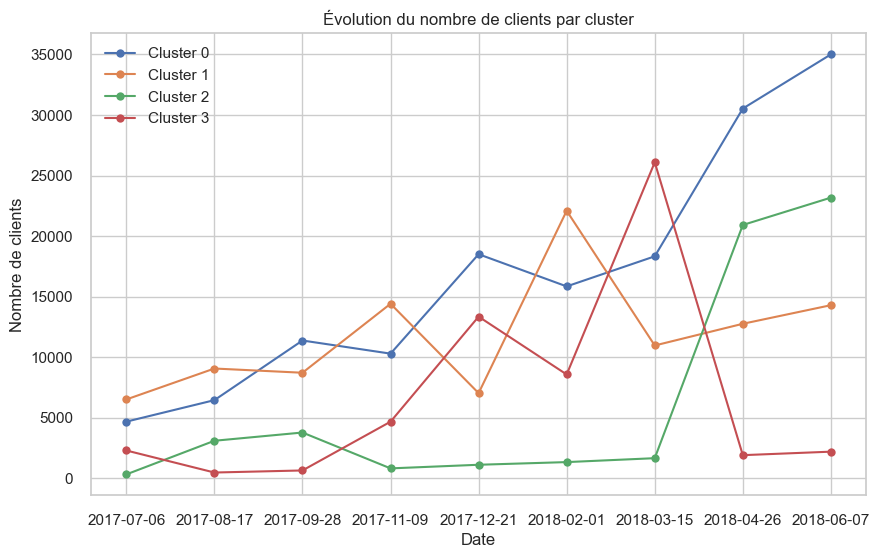

In [19]:
# Evolution du nombre de client par cluster au cours du temps
plot_cluster_counts(cluster_counts_df)

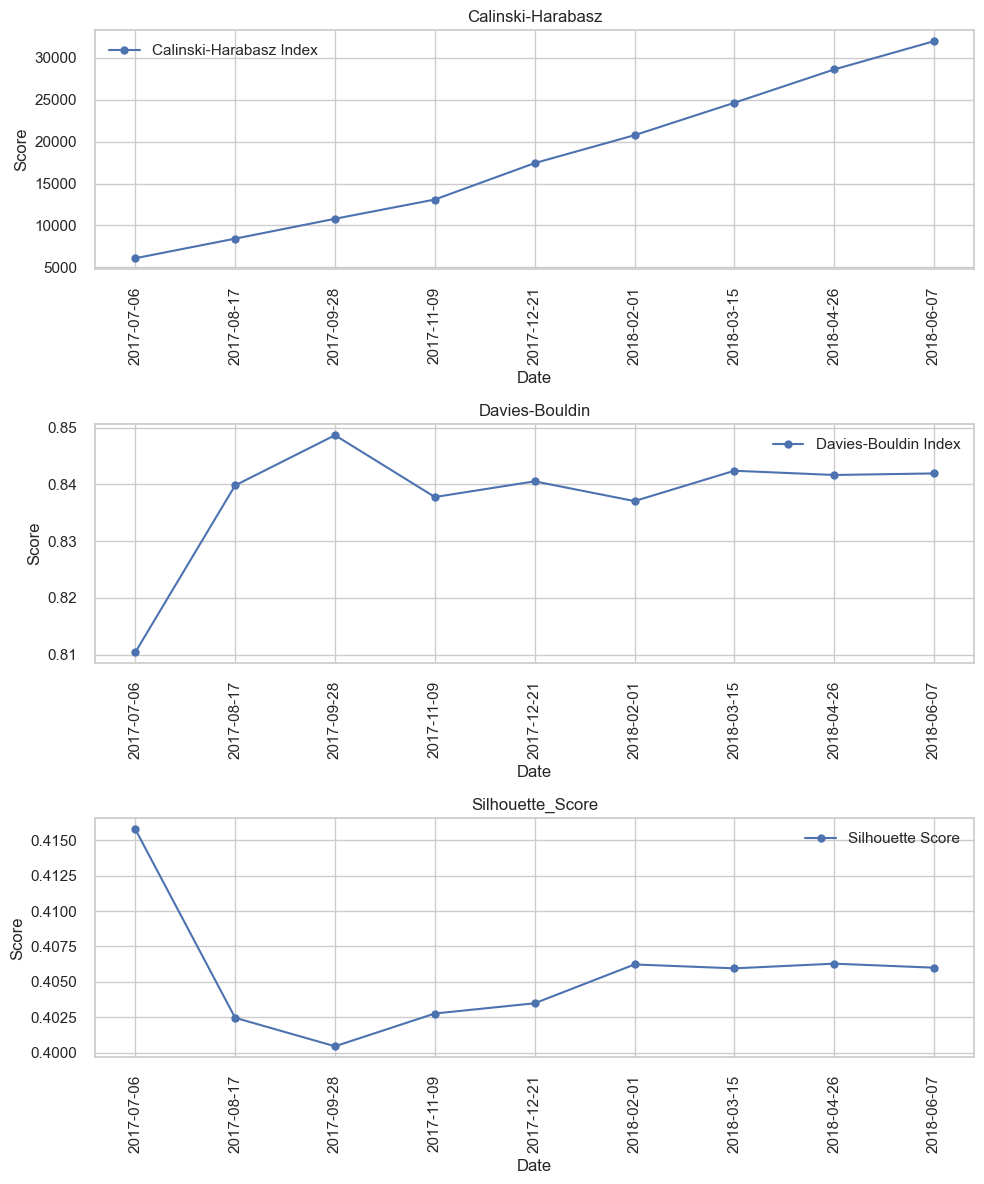

In [20]:
# Evaluation des clusters lors des maintenances
plot_ch_db_scores(ch_db_df)

# Contrôle marketing

##  Période de promotion

Rajout d'un contrôle des périodes de promotion qui impact localement le clustering.

In [21]:
# Black friday en 2017 = 24 novembre 2017

# Création dataframe avec les dates des promotions
data_sales = {
    'Sales': ['Black friday', 'Black friday'],
    'Dates': ['2017-11-24', '2018-11-23']
}

data_sales = pd.DataFrame(data_sales)

# Convertion des dates au bon format 
data_sales['Dates'] = pd.to_datetime(data_sales['Dates'])

display(data_sales)

,Sales,Dates
0,Black friday,2017-11-24
1,Black friday,2018-11-23


In [22]:
# On exclu de data_customers les périodes de promotion

print("Avant suppression:")
display(data_customers[data_customers['date'] == '2017-11-24'].head())

data_customers = data_customers[~data_customers['date'].isin(data_sales['Dates'])]

# Afficher les lignes de data_customers où la date est '2017-11-24' après suppression
print("Après suppression:")
display(data_customers[data_customers['date'] == '2017-11-24'])

Avant suppression:


,order_id,product_id,price,payment_type,payment_value,review_score,order_status,date,order_delivered_customer_date,product_category_name,product_photos_qty,product_description_lenght,customer_unique_id,customer_state,order_delivered_days,panier_moyen
90,c442abd5622d3602e7e1951edacfd007,d63c1011f49d98b976c352955b1c4bea,59.99,credit_card,69.33,3,delivered,2017-11-24,2017-11-29 18:10:00,beleza_saude,1.0,614.0,59213e6a25258039405a711ff8dac4f1,SP,4,69.33
219,3853bb442103dd1f77271b7750bd3202,99a4788cb24856965c36a24e339b6058,89.90,credit_card,111.02,2,delivered,2017-11-24,2018-01-03 18:52:37,cama_mesa_banho,1.0,245.0,9f070a3e9a52bbc35fe2c833660d2330,RJ,40,111.02
245,44c86e534686d17733facffd8201375d,99a4788cb24856965c36a24e339b6058,89.90,credit_card,106.16,2,delivered,2017-11-24,2017-12-02 10:59:15,cama_mesa_banho,1.0,245.0,8c34ccb096a609feeb7e362837549dcf,SP,7,106.16
257,47e6a0c0327dc37d68fe995d4d254885,99a4788cb24856965c36a24e339b6058,89.90,credit_card,89.90,1,delivered,2017-11-24,2017-12-04 22:13:27,cama_mesa_banho,1.0,245.0,4b318eb7137fa528187f45aa9f73d30a,SP,9,384.58
258,47e6a0c0327dc37d68fe995d4d254885,3ab181ea2f9cc4be74bad27ef8a03492,259.90,credit_card,384.58,1,delivered,2017-11-24,2017-12-04 22:13:27,cama_mesa_banho,1.0,293.0,4b318eb7137fa528187f45aa9f73d30a,SP,9,384.58


Après suppression:


,order_id,product_id,price,payment_type,payment_value,review_score,order_status,date,order_delivered_customer_date,product_category_name,product_photos_qty,product_description_lenght,customer_unique_id,customer_state,order_delivered_days,panier_moyen


## Test maintenance avec contrôle marketing

In [27]:
end_date = pd.to_datetime('2018-06-01')
n_clusters = 4
cluster_counts_df, ari_df, ch_db_df = km_cluster_maintenance(end_date, n_clusters)

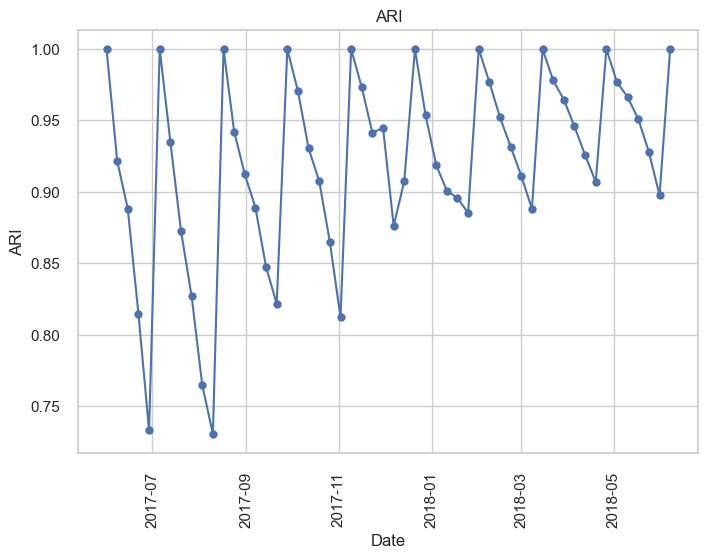

In [28]:
ari_graph(ari_df)

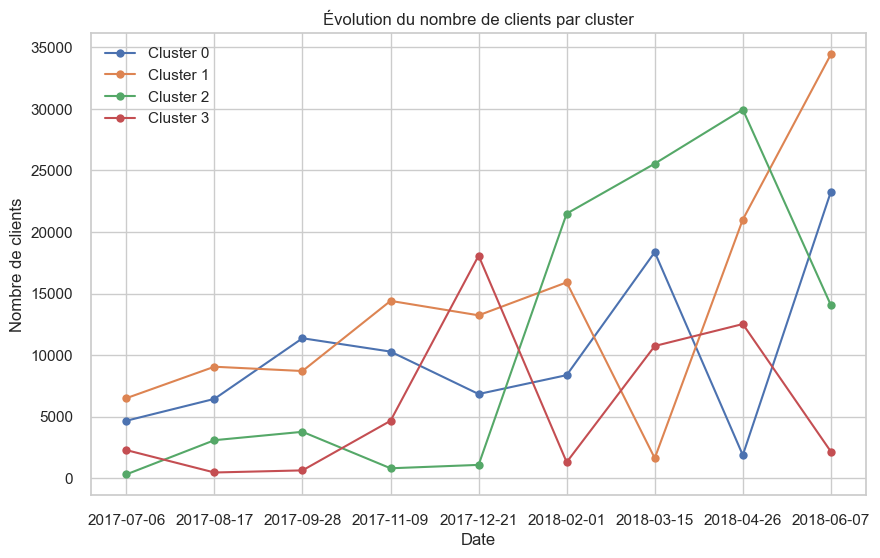

In [29]:
# Evolution du nombre de client par cluster au cours du temps
plot_cluster_counts(cluster_counts_df)

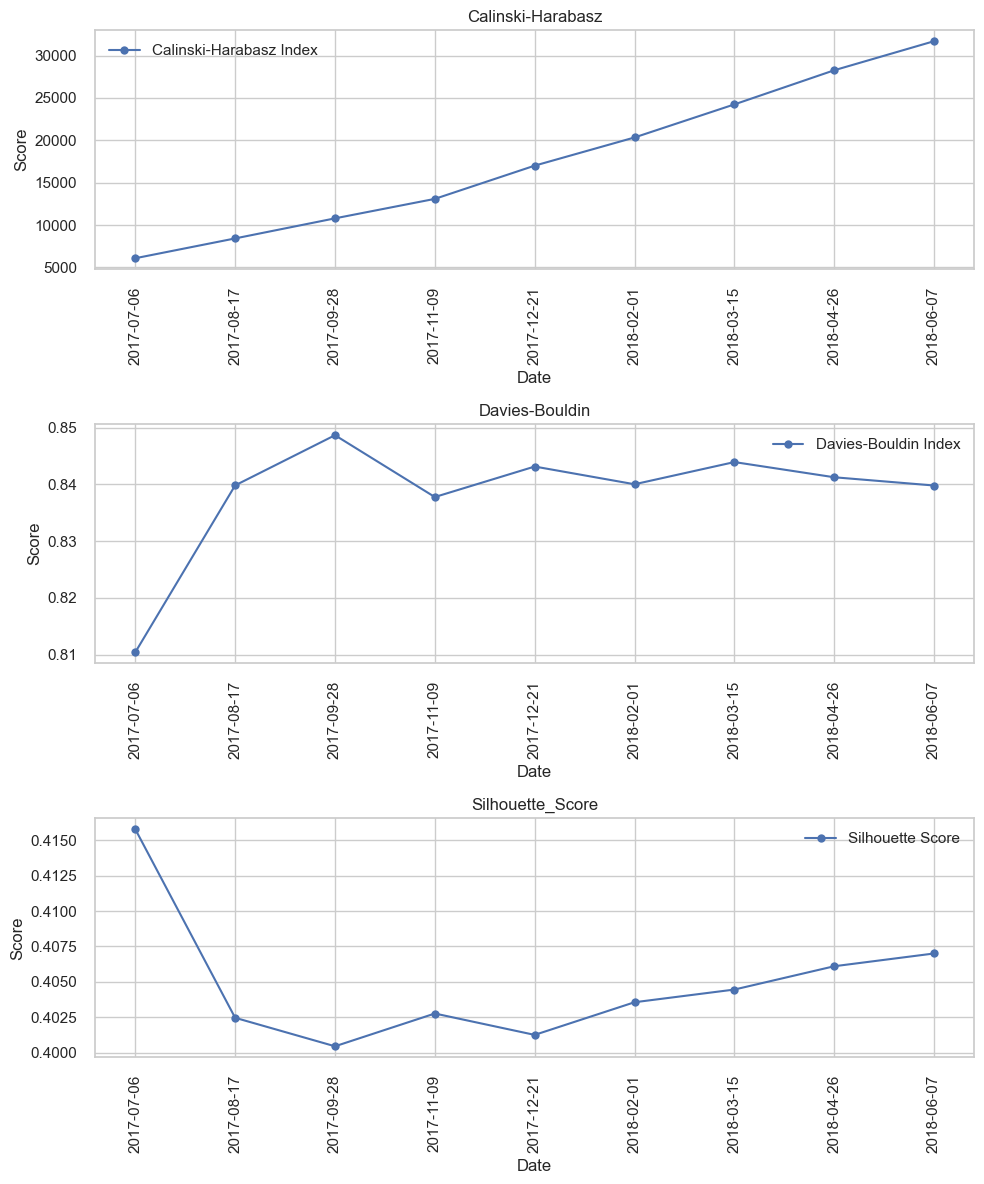

In [30]:
# Evaluation des clusters lors des maintenances
plot_ch_db_scores(ch_db_df)

# Conclusion



**Point général**
Il est important d'inclure les événements important qui impact le clustering comme le black friday dans le traitement des données. De plus, la modification d'une offre de l'entreprise peut amener à une clusterisation différentes avec potentiellement un nombre de cluster différent.  

**Recommandation**
Pour une segmentation selon RFM en 4 clusters, il est recommandé de faire une maintenance toutes les 5 semaines.